# Sprawozdanie z cw.2 Antoni Kois gr.2

In [31]:
!pip3 install openpyxl seaborn scikit-learn statsmodels
import pandas as pd

# Wczytanie danych z pliku
df = pd.read_excel('../cw1/dane_przekrojowe_przykład.xlsx')

# Podstawowe statystyki opisowe
print(df.describe())

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.
               year          price        mileage           tax           mpg  \
count  10668.000000   10668.000000   10668.000000  10668.000000  10668.000000   
mean    2017.100675   22896.685039   24827.244001    126.011436     50.770022   
std        2.167494   11714.841888   23505.257205     67.170294     12.949782   
min     1997.000000    1490.000000       1.000000      0.000000     18.900000   
25%     2016.000000   15130.750000    5968.750000    125.000000     40.900000   
50%     2017.000000   20200.000000   19000.000000    145.000000     49.600000   
75%     2019.000000   27990.000000   36464.500000    145.000000     58.900000   
max     2020.000000  145000.000000  323000.000000    580.000000    188.300000   

         engineSize  
count  10668.000000  
mean       

# Zadanie 1. Przygotowanie danych

### 1.1
Na podstawie współczynników zmienności i współczynników korelacji ocenić, czy któreś ze
zmiennych (wszystkich dostępnych) powinny zostać wyeliminowane przed przystąpieniem do
budowy modelu ekonometrycznego.

### 1.2
Zmodyfikować dostępny zbiór danych (rozważyć przekształcenia zmiennych, eliminację pewnych
obserwacji).

### 1.3
Dokonać podziału zbioru danych na zbiór uczący (90% obserwacji) i testowy (10% obserwacji).
Porównać statystyki na zbiorze uczącym i testowym. W jakim celu wykonywany jest ten podział? 


Współczynniki zmienności dla naszego zbioru:
year          0.001075
price         0.511615
mileage       0.946708
tax           0.533024
mpg           0.255056
engineSize    0.312283
dtype: float64


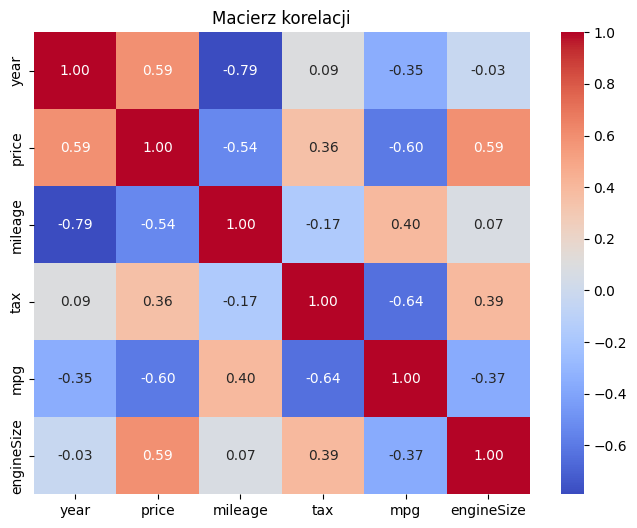

In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import variation
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

# Obliczenie współczynników zmienności
num_cols = ['year', 'price', 'mileage', 'tax', 'mpg', 'engineSize']
cv = df[num_cols].apply(lambda x: variation(x, nan_policy='omit'))
print("\nWspółczynniki zmienności dla naszego zbioru:")
print(cv)

# Obliczenie macierzy korelacji aby sprawdzić jak łątwiej sprawdzić jak one wyglądają
correlation_matrix = df[num_cols].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Macierz korelacji")
plt.show()

In [33]:
# Usuwanie obserwacji odstających na podstawie ceny (5 i 95 percentyl)
lower, upper = df['price'].quantile([0.05, 0.95])
df = df[(df['price'] >= lower) & (df['price'] <= upper)]

# Usunięcie obserwacji, gdzie engineSize = 0, ponieważ jest to prawdopodobnie zastąpienie wartości NaN
df = df[df['engineSize'] > 0]

# Dodanie nowej kolumny - wiek samochodu. Gdyż poprostu dla roku współczynnik zmienności jest mały i bez senus jest go porównywać
df['car_age'] = 2025 - df['year']
df.drop(columns=['year'], inplace=True)  # Usunięcie kolumny 'year', nie jest już nam potrzebna

# Usunięcie zmiennej 'mileage' (zbyt duża korelacja z rokiem, więc zostawiamy tylko jedną zmienną objaśniającą z tych dwóch)
df.drop(columns=['mileage'], inplace=True)

# Usunięcie wierszy, gdzie fuelType = Hybrid, gdyż wyraźnie widać, że tych aut ilościowo jest sporo mniej
df = df[df['fuelType'] != 'Hybrid']

# Usunięcie kolumny 'model', gdyż jest zmienną kategoryczną i ma zbyt wiele różnych wartości. Albo można "model" połączyć w mniejsze grupy i wtedy zmienić na faktory
df.drop(columns=['model'], inplace=True)

# Konwersja zmiennych kategorycznych na numeryczne (faktory)
df = pd.get_dummies(df, columns=['transmission', 'fuelType'], drop_first=True)

# Ponowne Sprawdzenie współczynników zmienności
num_cols = ['price', 'tax', 'mpg', 'engineSize', 'car_age']
cv = df[num_cols].apply(lambda x: variation(x, nan_policy='omit'))
print("\nWspółczynniki zmienności:")
print(cv)

# sprawdzenie czy nie ma kolumn kategorycznych
df.info()


Współczynniki zmienności:
price         0.358688
tax           0.501811
mpg           0.215384
engineSize    0.264691
car_age       0.230671
dtype: float64
<class 'pandas.core.frame.DataFrame'>
Index: 9536 entries, 0 to 10667
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   price                   9536 non-null   int64  
 1   tax                     9536 non-null   int64  
 2   mpg                     9536 non-null   float64
 3   engineSize              9536 non-null   float64
 4   car_age                 9536 non-null   int64  
 5   transmission_Manual     9536 non-null   bool   
 6   transmission_Semi-Auto  9536 non-null   bool   
 7   fuelType_Petrol         9536 non-null   bool   
dtypes: bool(3), float64(2), int64(3)
memory usage: 474.9 KB


In [ ]:
# Konwersja bool na int, ponieważ metoda OLS nie przyjmuje typu boolean
df[df.select_dtypes(['bool']).columns] = df.select_dtypes(['bool']).astype(int)

# Podział na zbiór uczący i testowy
train_df, test_df = train_test_split(df, test_size=0.1, random_state=42)

# Porównanie statystyk zbiorów
print("\nStatystyki zbioru uczącego:")
print(train_df.describe())
print("\nStatystyki zbioru testowego:")
print(test_df.describe())


# Budowa modelu ekonometrycznego
X_train = train_df.drop(columns=['price'])
X_train[X_train.select_dtypes(['bool']).columns] = X_train.select_dtypes(['bool']).astype(int)  # Konwersja bool na int
y_train = train_df['price']
X_train = sm.add_constant(X_train)  # Dodanie stałej do modelu, w R funckja lm jest dodawan pod spodem w trakcie
model = sm.OLS(y_train, X_train).fit()

# Podsumowanie modelu
print(model.summary())

# Przetestowanie na danych testowych
X_test = test_df.drop(columns=['price'])
y_test = test_df['price']
X_test = sm.add_constant(X_test)  # Dodanie stałej
y_pred = model.predict(X_test)

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Średni błąd bezwzględny - Mean Absolute Error (MAE): {mae}")
print(f"Średni błąd kwadratowy - Mean Squared Error (MSE): {mse}")
print(f"R²: {r2}")


# sprawdzić istotnośc zmiennych przez p-value (powinno być niskie)
# sprawdzić R jak dużo danych jest opisanych przez model
# polepszyć model w zależności od istotności zmiennej, sprawdzać usuwajać po jednej zmiennej nieistotnej
# w R linearHyphotesis do sprawdzania czy parametr przy danej zmiennej jest 0 -> czyli czy jest nieistotna
# sprawdzić korlacja vs "coefficients" z modelu
# współliniowość R car::vif(model) powinno być < 5
# test RESET - RAMSEYA w R resettest
# test CHOWA - czy parametry modelu są stabilne
# Gdy wiemy, że model jest poprawny to wteyd przechodzimy do weryfikacji parametrów

# PROGNOZA
# 



Statystyki zbioru uczącego:
              price          tax          mpg   engineSize      car_age  \
count   8582.000000  8582.000000  8582.000000  8582.000000  8582.000000   
mean   21813.854230   126.040550    50.921277     1.874878     7.737357   
std     7849.248309    63.516488    10.984842     0.496282     1.785620   
min     9950.000000     0.000000    20.300000     1.000000     5.000000   
25%    15798.000000   125.000000    42.200000     1.500000     6.000000   
50%    20003.500000   145.000000    50.400000     2.000000     8.000000   
75%    26990.000000   145.000000    57.700000     2.000000     9.000000   
max    45000.000000   580.000000   156.900000     6.300000    19.000000   

       transmission_Manual  transmission_Semi-Auto  fuelType_Petrol  
count          8582.000000             8582.000000      8582.000000  
mean              0.408529                0.346539         0.498252  
std               0.491591                0.475895         0.500026  
min            

Podział na model uczący i uczony jest po to, by móc sprawdzić czy nasz model faktycznie działa odpowiednio, a do tego potrzebujemy danych, które model jeszcze "nie widział", gdyż istnieje ryzyko, że model działa znakomicie, ale tylko na danych które zna.

Po przeprowadzonym teście wynika, że średnio model myli się o 2458.84 £ w cenie.
MSE jest bardziej wrażliwy na duże błędy (przez podnoszenie do kwadratu), więc wysokie wartości mogą sugerować, że niektóre przewidywania są znacząco nietrafione.
R² (współczynnik determinacji) wynosi 0.827, co oznacza, że model wyjaśnia 82,7% wariancji cen samochodów, jest to dość spora ilość i wskazuje początkowo iż nasz model jest dobry